# **LiDAR Point clouds to 3D surfaces** ✨➡️🏔️

In this final tutorial, let's use PyGMT to
perform a more advanced geoprocessing workflow 😎

Specifically, we'll learn to filter and interpolate
a LiDAR point cloud onto a regular grid surface 🏁

At the end, we'll also make a 🚠 3D perspective plot for
the Digital Surface Model (DSM) produced through this exercise!

## 🎉 Getting started

Begin by importing some Python 🐍 libraries.

Besides [pygmt](https://www.pygmt.org), we'll also be using:

- [laspy](https://github.com/laspy/laspy) to read in LAZ LiDAR files 🌃
- [pandas](https://pandas.pydata.org) for managing tabular data 🀤
- [rioxarray](https://corteva.github.io/rioxarray) to export our DSM to a GeoTIFF 🗺️

In [1]:
import laspy
import pandas as pd
import pygmt
import rioxarray
import xarray as xr

# 0️⃣ The LiDAR data

Let's visit [Wellington](https://en.wikipedia.org/wiki/Wellington)
which is the capital city of New Zealand 🇳🇿.

They recently had a LiDAR survey done between March 2019 to March 2020 🛩️,
with the point cloud and derived products published under an open
[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.

- OpenTopography link: https://doi.org/10.5069/G9K935QX
- Bulk download location: https://opentopography.s3.sdsc.edu/minio/pc-bulk/NZ19_Wellington
- Official 1m DSM from LINZ: https://data.linz.govt.nz/layer/105024-wellington-city-lidar-1m-dsm-2019-2020

🔖 References:
- https://medium.com/on-location/from-points-to-pixels-creating-digital-elevation-models-from-open-topography-point-clouds-abe616d06860
- https://github.com/GenericMappingTools/foss4g2019oceania/blob/v1/3_lidar_to_surface.ipynb
- https://github.com/weiji14/30DayMapChallenge2021/blob/v0.3.1/day17_land.py

First though, we'll need to download a sample file to play with 🎮

Luckily for us,
there is a function called [pygmt.which](https://www.pygmt.org/v0.6.1/api/generated/pygmt.which)
that has to ability to do just that!

The `download=True` option can be used to download ⬇️ a remote file to our local working directory.

In [2]:
# Download LiDAR LAZ file from a URL
lazfile = pygmt.which(
    fname="https://opentopography.s3.sdsc.edu/pc-bulk/NZ19_Wellington/CL2_BQ31_2019_1000_2138.laz",
    download=True,
)
print(lazfile)

CL2_BQ31_2019_1000_2138.laz


## Loading a point cloud 🌧️

Now we can use [laspy](https://laspy.readthedocs.io) to read in our example LAZ file
into a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.DataFrame.html).

The data will be kept in a variable called 'df' which stands for dataframe.

In [3]:
# Load LAZ data into a pandas DataFrame
lazdata = laspy.read(source=lazfile)
df = pd.DataFrame(
    data={
        "x": lazdata.x.scaled_array(),
        "y": lazdata.y.scaled_array(),
        "z": lazdata.z.scaled_array(),
        "classification": lazdata.classification,
    }
)

## Quick data preview ⚡

Let's get the bounding box 📦 region of our study area using
[pygmt.info](https://www.pygmt.org/v0.6.1/api/generated/pygmt.info.html).

In [4]:
# Get bounding box region
region = pygmt.info(data=df[["x", "y"]], spacing=1)  # West, East, South, North
print(f"Data points covers region: {region}")

Data points covers region: [1749760. 1750240. 5426880. 5427600.]


Check how many 🗃️ data points (rows) are in the table
and get some summary statistics printed out.

In [5]:
# Print summary statistics
print(f"Total of {len(df)} data points")
df.describe()

Total of 7322702 data points


x             y             z  classification
count  7.322702e+06  7.322702e+06  7.322702e+06    7.322702e+06
mean   1.750009e+06  5.427144e+06  6.536329e+01    4.477295e+00
std    1.337038e+02  1.713325e+02  4.428189e+01    2.212308e+00
min    1.749760e+06  5.426880e+06 -1.377360e+02    1.000000e+00
25%    1.749896e+06  5.426997e+06  3.380700e+01    3.000000e+00
50%    1.750012e+06  5.427125e+06  6.012200e+01    5.000000e+00
75%    1.750121e+06  5.427280e+06  9.645000e+01    5.000000e+00
max    1.750240e+06  5.427600e+06  3.186180e+02    1.800000e+01

More than 7 million points, that's a lot! 🤯

Let's try to take a quick look of our LiDAR elevation points on a map 🗺️

PyGMT *can* plot these many points, but it might take a long time ⏳,
so let's do a quick filter by taking every
[n-th row](https://stackoverflow.com/questions/25055712/pandas-every-nth-rowhttps://stackoverflow.com/questions/25055712/pandas-every-nth-row)
from our dataframe table.

In [6]:
df_filtered = df.iloc[::20]
print(f"Filtered down to {len(df_filtered)} data points")

Filtered down to 366136 data points


Now we can visualize these quickly on a map with PyGMT 😀

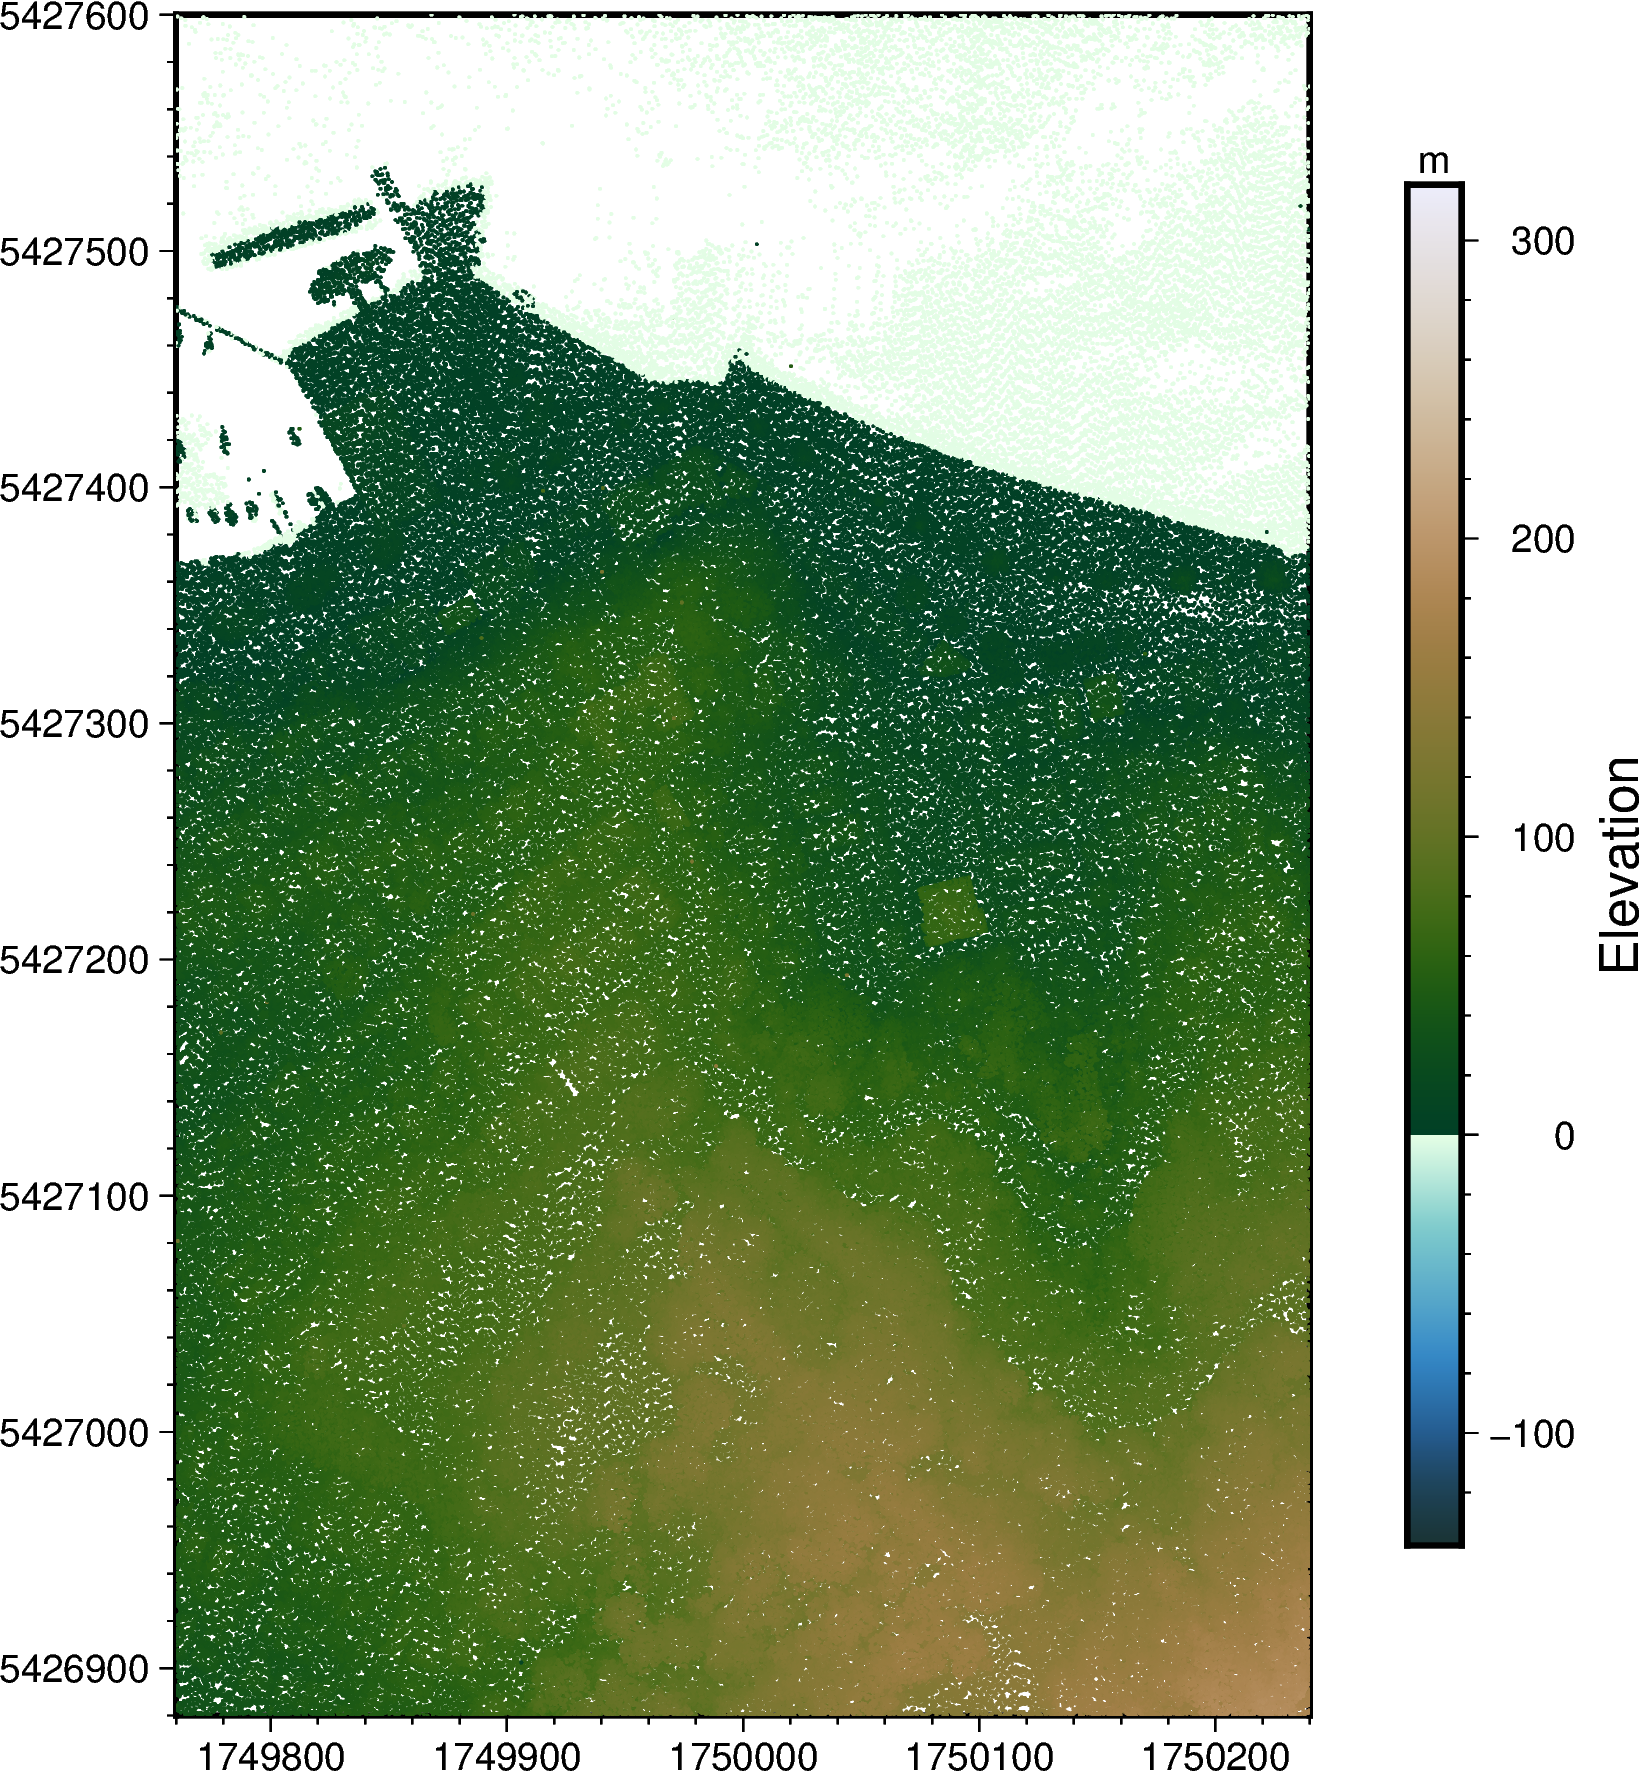

In [7]:
# Plot XYZ points on a map
fig = pygmt.Figure()
fig.basemap(frame=True, region=region, projection="x1:5000")
pygmt.makecpt(cmap="bukavu", series=[df.z.min(), df.z.max()])
fig.plot(
    x=df_filtered.x, y=df_filtered.y, color=df_filtered.z, style="c0.03c", cmap=True
)
fig.colorbar(position="JMR", frame=["af+lElevation", "y+lm"])
fig.show()

It's hard to make out what the objects are,
but hopefully you'll see what looks like a wharf with ⛵ boats on the top left corner.

This is showing us a part of Oriental Bay in Wellington,
with Mount Victoria ⛰️ towards the Southeast corner of the map.

# 1️⃣ Creating a Digital Surface Model (DSM)

Let's now produce a digital surface model from our point cloud 🌧️

We'll first do some proper spatial data cleaning 🧹 using both
[pandas](https://pandas.pydata.org) and [pygmt](https://www.pygmt.org).

First step is to remove the LiDAR points classified as high noise 🔊
which is done by querying all the points that are not '18'.

🔖 References:
- Table 17 of [ASPRS LAS Specification](https://www.asprs.org/a/society/committees/standards/LAS_1_4_r13.pdf)

In [8]:
df = df.query(expr="classification != 18")
df

x           y      z  classification
0        1749771.56  5427498.77 -0.724               2
1        1749771.52  5427498.46 -0.708               2
2        1749771.48  5427498.15 -0.700               2
3        1749771.45  5427497.84 -0.683               2
4        1749771.41  5427497.54 -0.630               2
...             ...         ...    ...             ...
7322687  1749760.95  5427567.17 -0.479               9
7322698  1749760.23  5427567.65 -0.488               9
7322699  1749760.26  5427567.98 -0.442               9
7322700  1749760.29  5427568.29 -0.417               9
7322701  1749760.32  5427568.62 -0.404               9

[7232453 rows x 4 columns]

## Get highest elevation points 🍫

Next, we'll use the
[blockmedian](https://www.pygmt.org/v0.6.1/api/generated/pygmt.blockmedian.html)
function to trim 🪒 down the points spatially.

By default, this function computes a single median elevation
for every pixel on an equally spaced grid 🏁

For a Digital **Surface** Elevation Model (DSM) though,
we should pick the highest elevation 🔝 instead of the median.

So we'll tell blockmedian to use the 99th
[quantile](https://docs.generic-mapping-tools.org/latest/blockmedian.html#t) (T) instead,
and set our output grid spacing to be exactly 1 metre (1+e) 📏

Note that we'll only be taking the 🇽, 🇾, 🇿 (elevation) columns for this.

In [9]:
# Preprocess LiDAR data using blockmedian
df_trimmed = pygmt.blockmedian(
    data=df[["x", "y", "z"]],
    T=0.99,  # 99th quantile, i.e. the highest point
    spacing="1+e",
    region=region,
)
df_trimmed

x           y        z
0       1749760.05  5427599.54   -0.755
1       1749760.67  5427599.83   -0.737
2       1749761.87  5427599.71   -0.747
3       1749765.39  5427599.55   -0.701
4       1749765.96  5427599.73   -0.742
...            ...         ...      ...
311584  1750236.41  5426880.41  178.756
311585  1750237.32  5426880.47  179.132
311586  1750238.50  5426880.40  179.232
311587  1750239.36  5426880.46  179.517
311588  1750239.99  5426880.49  179.622

[311589 rows x 3 columns]

## Turn points into a grid 🫓

Lastly, we'll use [pygmt.surface](https://www.pygmt.org/v0.6.1/api/generated/pygmt.surface.html)
to produce a grid from the 🇽, 🇾, 🇿 data points.

Make sure to set our desired grid spacing to be exactly 📏 1 metre (1+e) again.

Also, we'll set a tension factor (T) of 0.35 which is suitable for steep topography
(since we have some 🏠 buildings with 'steep' vertical edges).

🚨 Note that this might take some time to run.

In [10]:
# Create a Digital Surface Elevation Model with
# a spatial resolution of 1m.
grid = pygmt.surface(
    x=df_trimmed.x,
    y=df_trimmed.y,
    z=df_trimmed.z,
    spacing="1+e",
    region=region,  # xmin, xmax, ymin, ymax
    T=0.35,  # tension factor
)

surface [WARNING]: 53246 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Let's take a look 👀 at the grid output.

The grid will be returned as an
[xarray.DataArray](https://docs.xarray.dev/en/v2022.03.0/generated/xarray.DataArray.html),
with each pixel's elevation (🇿 value in metres) stored at every 🇽 and 🇾 coordinate.

In [11]:
grid

<xarray.DataArray 'z' (y: 721, x: 481)>
array([[ 32.827084  ,  33.058956  ,  33.236935  , ..., 179.27199   ,
        179.47954   , 179.68286   ],
       [ 32.929073  ,  33.571014  ,  33.91027   , ..., 178.95854   ,
        179.3416    , 179.49734   ],
       [ 32.99532   ,  34.62854   ,  35.717705  , ..., 178.77904   ,
        179.26633   , 179.20392   ],
       ...,
       [ -0.7089864 ,  -0.7099118 ,  -0.7231264 , ...,  -0.68712777,
         -0.67993474,  -0.65520626],
       [ -0.7150018 ,  -0.72270995,  -0.7585947 , ...,  -0.6843457 ,
         -0.68121314,  -0.6624484 ],
       [ -0.7903585 ,  -0.75000775,  -0.78331774, ...,  -0.70826954,
         -0.68685687,  -0.6937212 ]], dtype=float32)
Coordinates:
  * x        (x) float64 1.75e+06 1.75e+06 1.75e+06 ... 1.75e+06 1.75e+06
  * y        (y) float64 5.427e+06 5.427e+06 5.427e+06 ... 5.428e+06 5.428e+06
Attributes:
    long_name:     z
    actual_range:  [ -1.83348048 192.18907166]

# 2️⃣ Plotting a Digital Surface Model (DSM)

## **Plot in 2D** 🏳️‍🌈

Now we can plot our Digital Surface Model (DSM) grid 🏁

This can be done by passing the
[xarray.DataArray](https://docs.xarray.dev/en/v2022.03.0/generated/xarray.DataArray.html)
grid into
[pygmt.Figure.grdimage](https://www.pygmt.org/v0.6.1/api/generated/pygmt.Figure.grdimage).

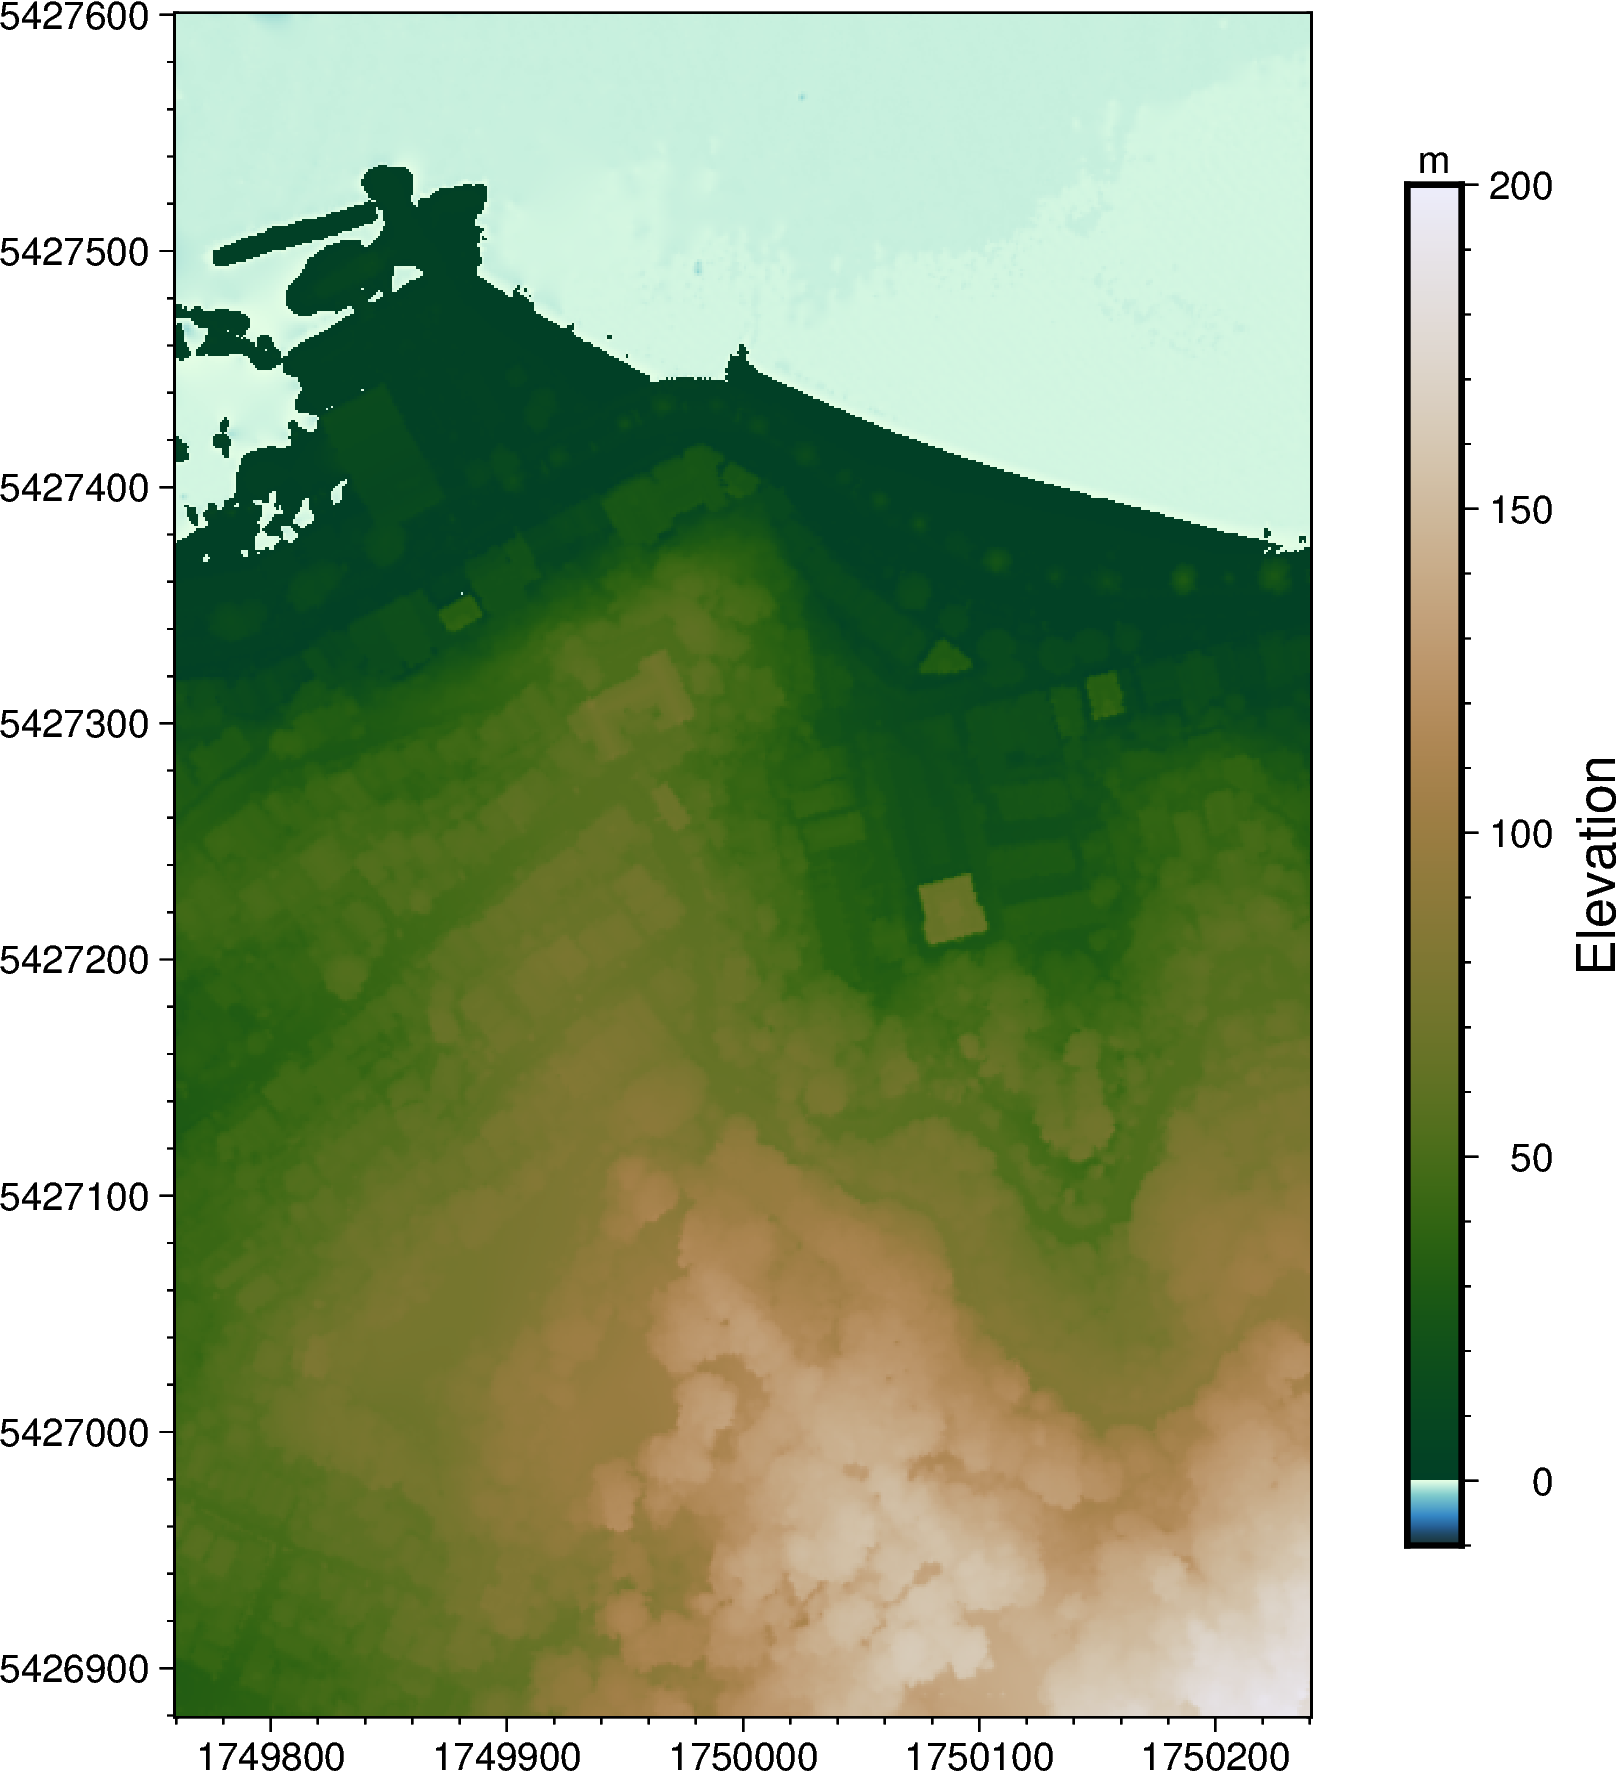

In [12]:
fig2 = pygmt.Figure()
fig2.basemap(
    frame=True,
    region=[1_749_760, 1_750_240, 5_426_880, 5_427_600],
    projection="x1:5000",
)
pygmt.makecpt(cmap="bukavu", series=[-10, 200])
fig2.grdimage(grid=grid)
fig2.colorbar(position="JMR", frame=["af+lElevation", "y+lm"])
fig2.show()

## Plot 3D perspective view ⛰️

Now comes the cool part 💯

PyGMT has a [grdview](https://pygmt-git-foss4g2019oceania.gmt.now.sh/api/generated/pygmt.Figure.grdview.html#pygmt.Figure.grdview)
function to make high quality 3D perspective plots of our elevation surface!

Besides providing the elevation 'grid', there are a few basic things to configure:
- cmap - name of 🌈 [colormap](https://docs.generic-mapping-tools.org/6.3/cookbook/cpts.html#id3) to use
- surftype - we'll use 's' here which just creates a regular surface 🏄
- perspective - set azimuth angle (e.g. 315 for NorthWest) and 📐 elevation (e.g 30 degrees) of the viewpoint
- zscale - a vertical exaggeration 🔺 factor, we'll use 0.02 here

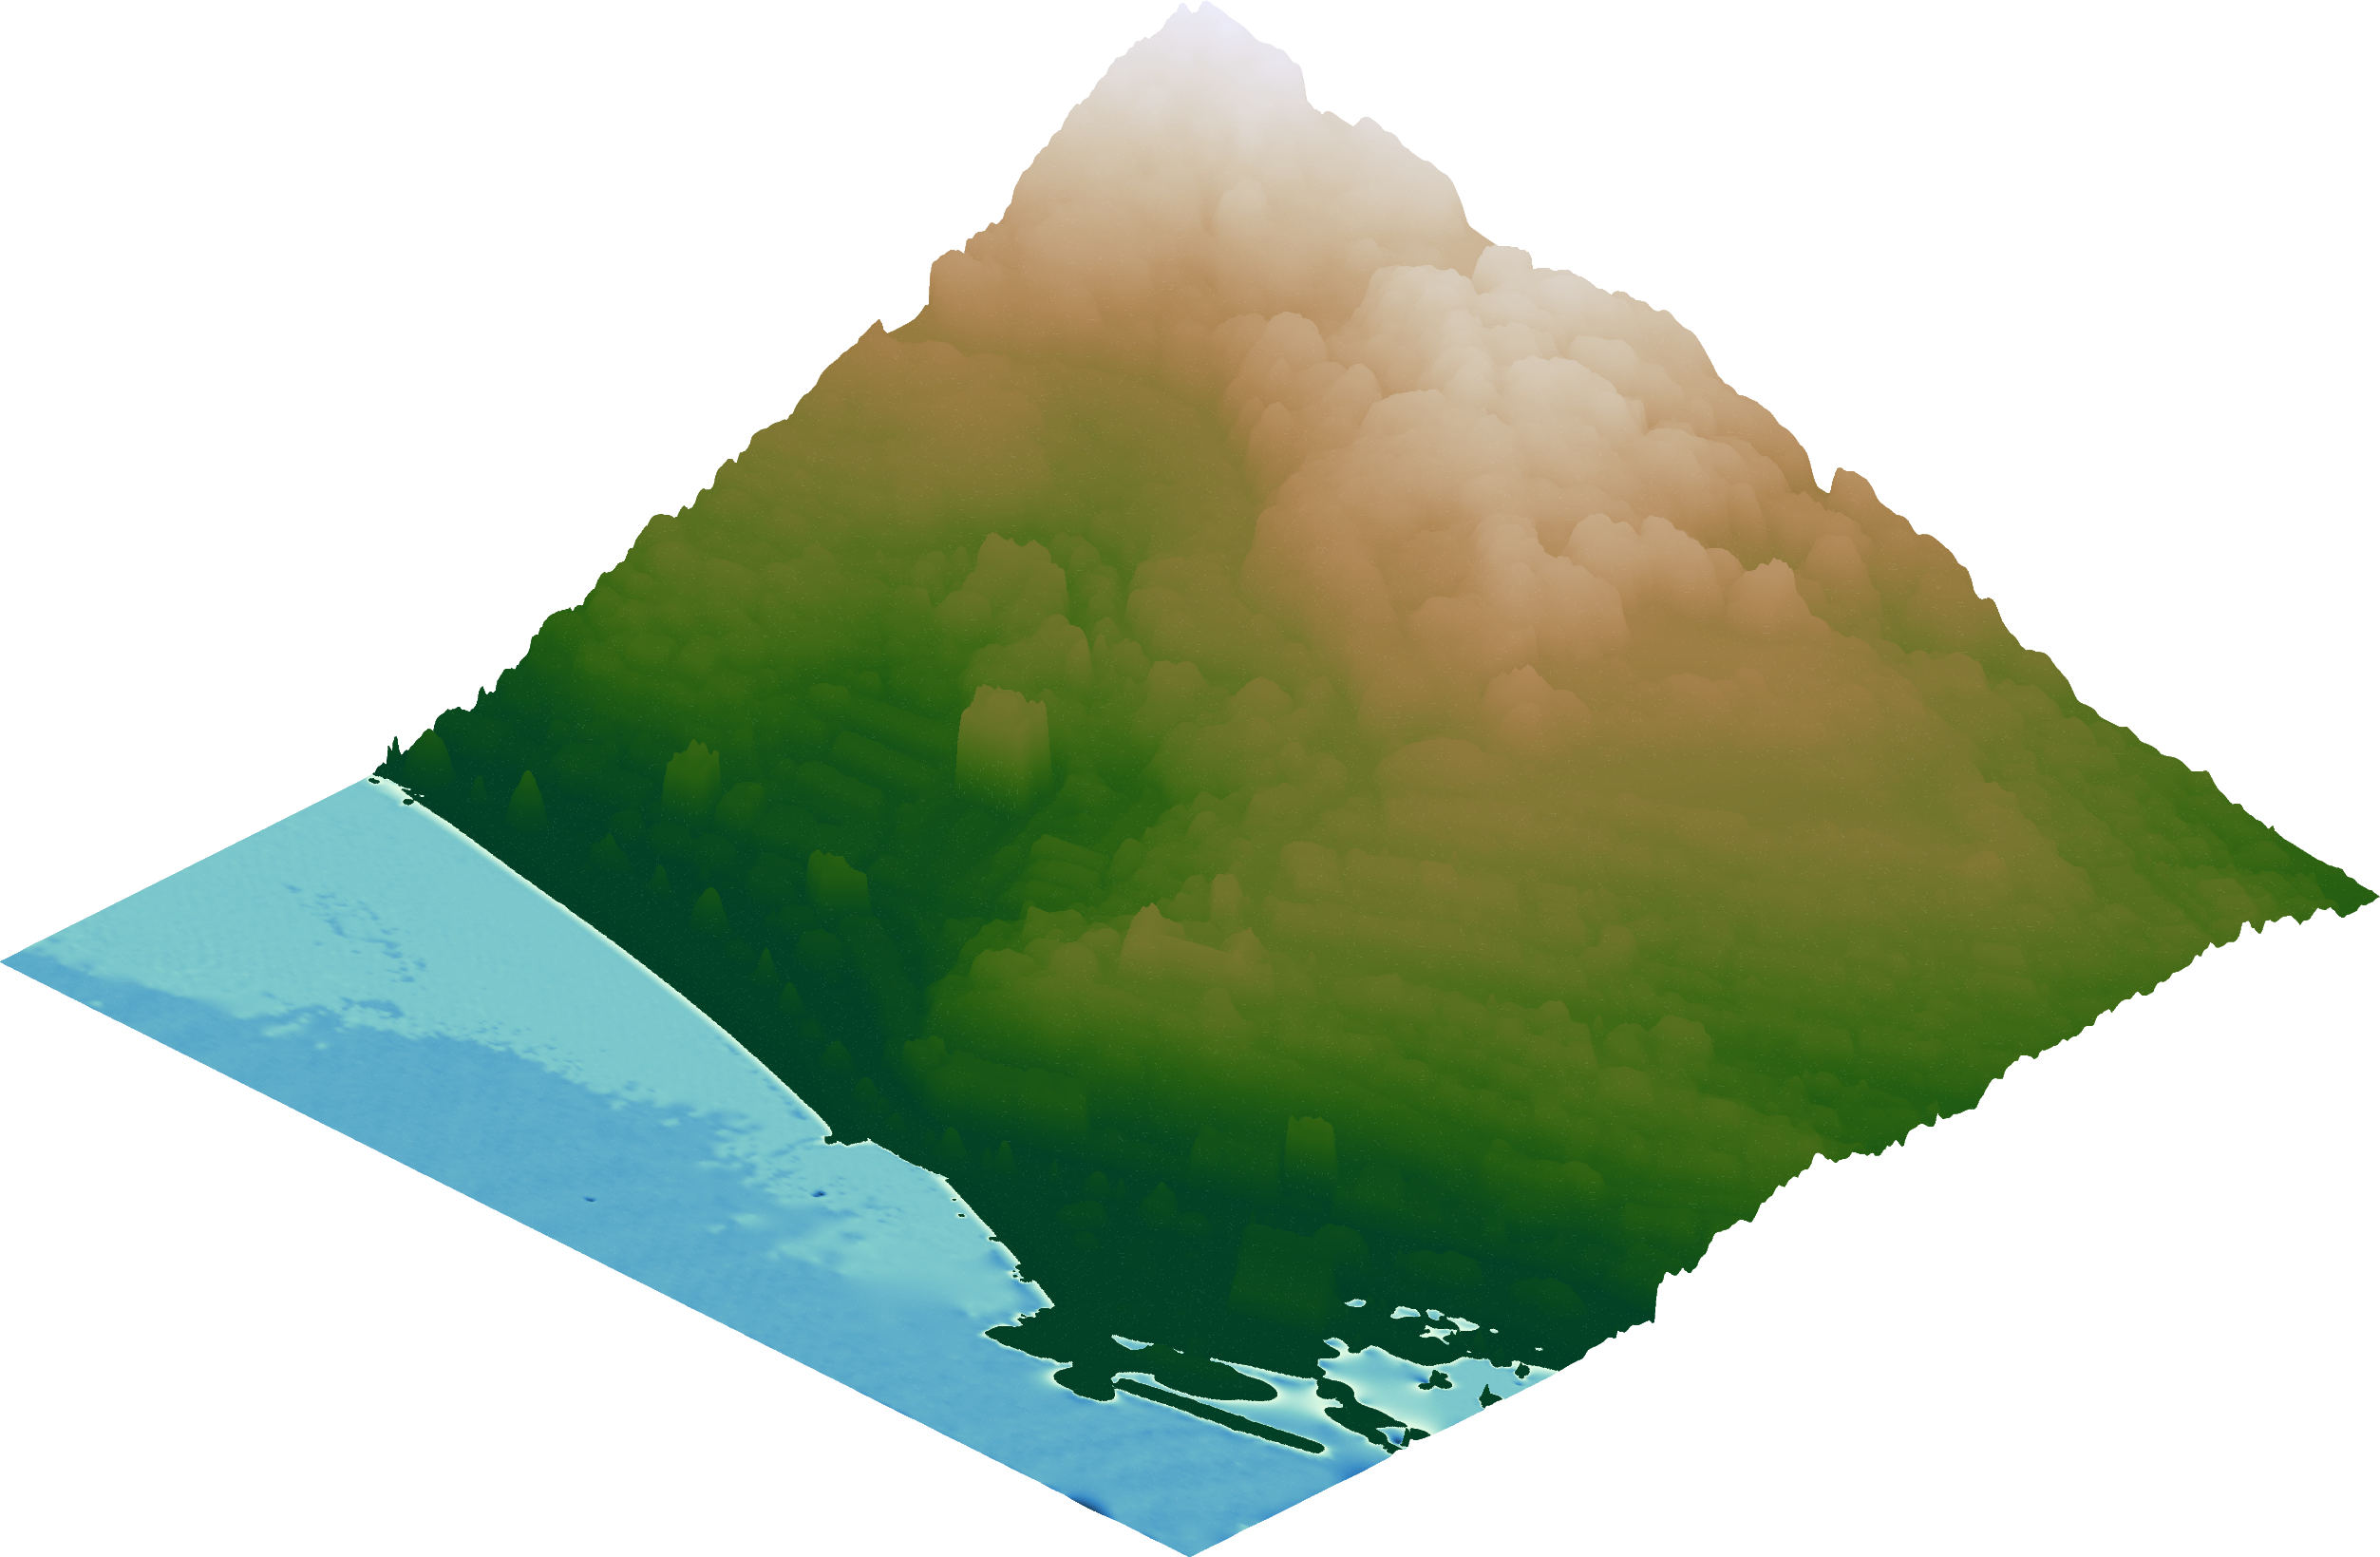

In [13]:
fig3 = pygmt.Figure()
fig3.grdview(
    grid=grid,
    cmap="bukavu",
    surftype="s",  # surface plot
    perspective=[315, 30],  # azimuth bearing, and elevation angle
    zscale=0.02,  # vertical exaggeration
)
fig3.show()

There are also other things we can 🧰 configure such as:

- Hillshading ⛱️ using `shading=True`
- A proper 3D map frame 🖼️ with:
  - automatic tick marks on x and y axis (e.g. `xaf+lLabel`)
  - z-axis automatic tick marks (`zaf+lLabel`)
  - plot title (`+tMy Title`)

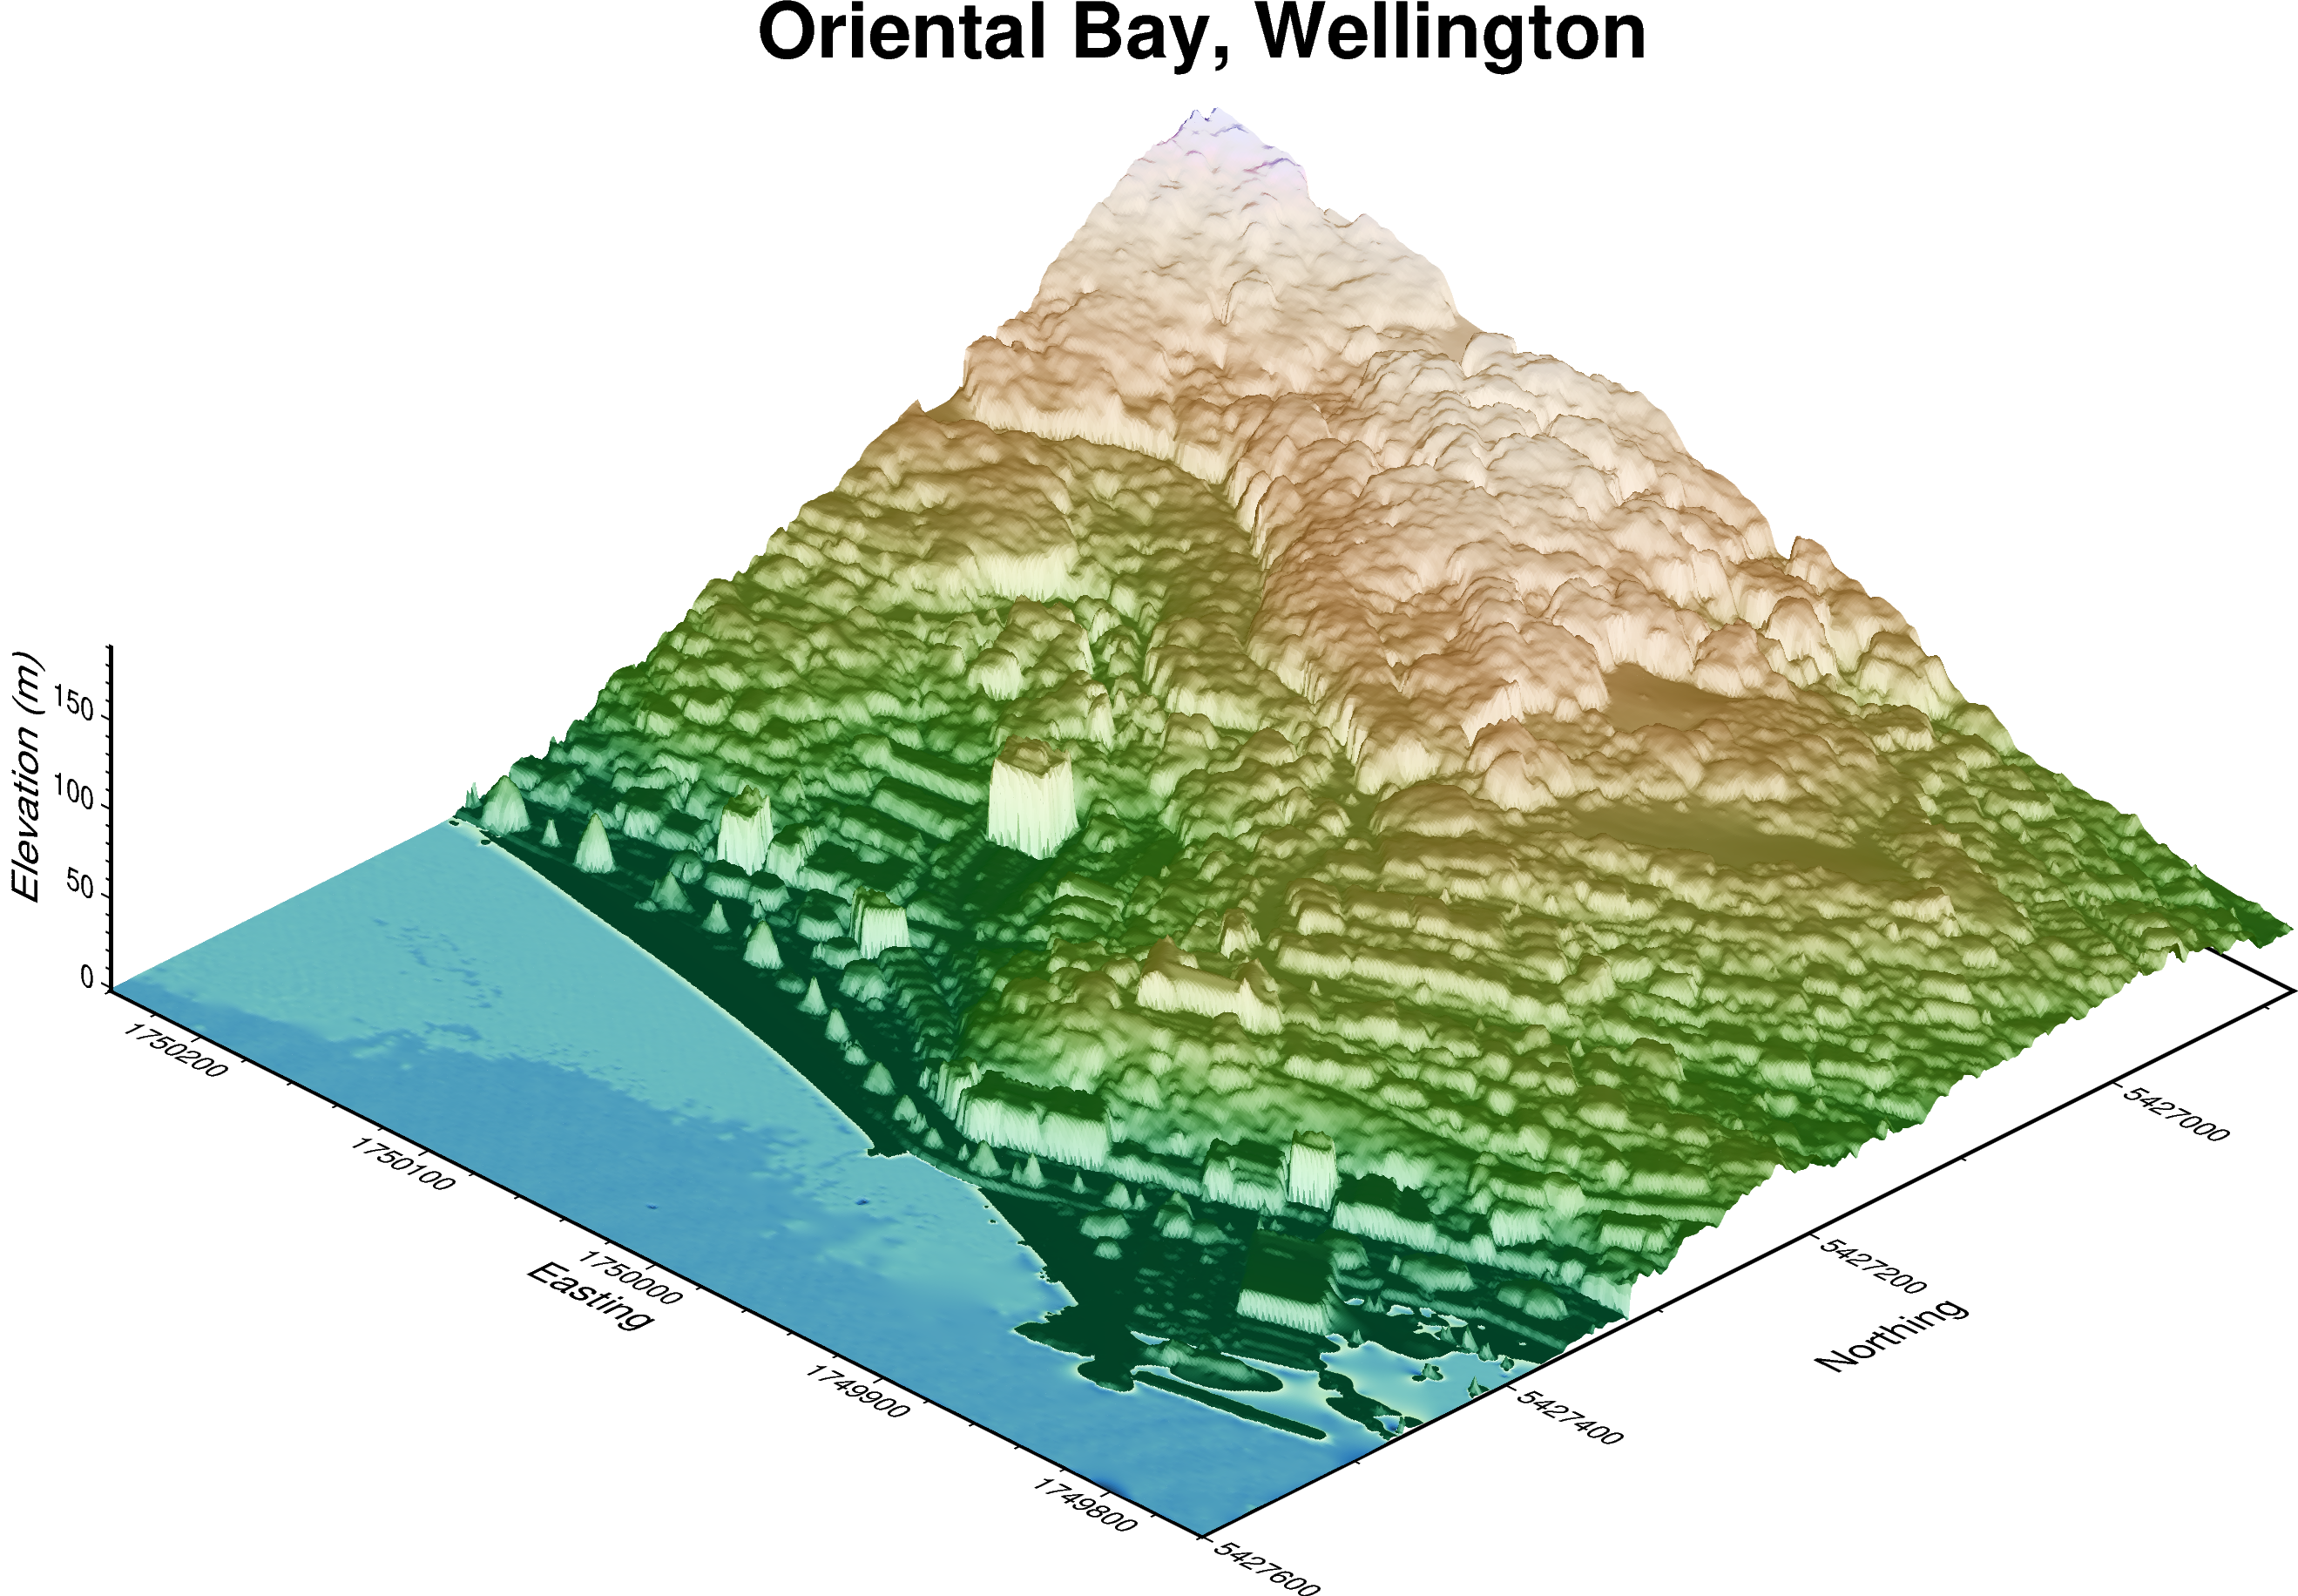

In [14]:
fig3 = pygmt.Figure()
fig3.grdview(
    grid=grid,
    cmap="bukavu",
    surftype="s",  # surface plot
    perspective=[315, 30],  # azimuth bearing, and elevation angle
    zscale=0.02,  # vertical exaggeration
    shading=True,  # hillshading
    frame=[
        'xaf+l"Easting"',
        'yaf+l"Northing"',
        'zaf+l"Elevation (m)"',
        "+tOriental Bay, Wellington",
    ],
)
fig3.show()

Feel free to have a go at changing the azimuth and elevation angle to get a different view 🔭

You can also try to tweak the vertical exaggeration factor 🗼
and play around with the map frame!

## Save figures and output DSM to GeoTIFF 💾

Time to save your work!

We'll save each of our figures into separate files first 🗃️

In [15]:
fig.savefig(fname="wellington_1d_lidar.png")
fig2.savefig(fname="wellington_2d_dsm_map.png")
fig3.savefig(fname="wellington_3d_dsm_view.png")

Also, it'll be good to have a proper GeoTIFF of the DSM we made.
This can be done using
[rioxarray's to_raster method](https://corteva.github.io/rioxarray/html/examples/convert_to_raster.html).

In [16]:
grid.rio.to_raster(raster_path="DSM_of_Wellington.tif")

The files should now appear on the file list on the left,
and you can download them to your computer.

# 3️⃣ Bonus exercise - Create a 3D surface map of another area

Here's a challenge to test your PyGMT skills 🤹

You'll be processing a LiDAR point cloud of a different area 📍 from start to finish.

Good luck! 🥳

Feel free to find a dataset from an area you're interested in using
[OpenTopography](https://portal.opentopography.org/datasets).

To make it easier though, I've provided an example for Queenstown, New Zealand 🇳🇿

- OpenTopography link: https://doi.org/10.5069/G9MP51G0
- Bulk download location: https://opentopography.s3.sdsc.edu/minio/pc-bulk/NZ21_Otago
- Official 1m DSM from LINZ: https://data.linz.govt.nz/layer/105905-otago-queenstown-lidar-index-tiles-2021

These files covers the Central Queenstown area:
  - https://opentopography.s3.sdsc.edu/pc-bulk/NZ21_Otago/CL2_CC11_2021_1000_0813.laz
  - https://opentopography.s3.sdsc.edu/pc-bulk/NZ21_Otago/CL2_CC11_2021_1000_0814.laz
  - https://opentopography.s3.sdsc.edu/pc-bulk/NZ21_Otago/CL2_CC11_2021_1000_0913.laz
  - https://opentopography.s3.sdsc.edu/pc-bulk/NZ21_Otago/CL2_CC11_2021_1000_0914.laz

## Download and load data

In [17]:
filenames = [
    # "",
]

df = pd.DataFrame()  # Start an empty DataFrame
for fname in filenames:
    lazfile = pygmt.which(fname=fname, download=True)

    lazdata = laspy.read(source=lazfile)
    temp_df = pd.DataFrame(
        data={
            "x": lazdata.x.scaled_array(),
            "y": lazdata.y.scaled_array(),
            "z": lazdata.z.scaled_array(),
            "classification": lazdata.classification,
        }
    )
    # load each point cloud into the DataFrame
    df = df.append(temp_df, ignore_index=True)

In [18]:
df

Empty DataFrame
Columns: []
Index: []

## Create a DSM

In [19]:
# Run blockmedian

In [20]:
# Run surface

## Plot the DSM

In [21]:
# Run grdimage

In [22]:
# Run grdview

That’s all 🎉!
For more information on how to customize your map 🗺️,
check out:

- Tutorials at https://www.pygmt.org/v0.6.1/tutorials/index.html
- Gallery examples at https://www.pygmt.org/v0.6.1/gallery/index.html

If you have any questions 🙋,
feel free to visit the PyGMT forum at
https://forum.generic-mapping-tools.org/c/questions/pygmt-q-a/11.

Submit any ✨ feature requests/bug reports to the GitHub repo at
https://github.com/GenericMappingTools/pygmt

Cheers!